## Descriptors-based regression

## 1. Using SIFT descriptors

<p style="font-family: calibri; font-size: 14px;">
References: <br>
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html
</p>

In [3]:
import sys
import os

sys.path.append(os.getcwd() + '/..')
sys.path.append(os.getcwd() + '/../..')

In [4]:
from get_data import load_data, load_label, fetch_particular_series, plot_series

In [5]:
import matplotlib.pyplot as plt

from skimage import data, transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

import cv2
import numpy as np

In [8]:
img1 = fetch_particular_series("009988", 1, data_directory="../../data/images/", grayscale=True)
img2 = fetch_particular_series("009988", 2, data_directory="../../data/images/", grayscale=True)

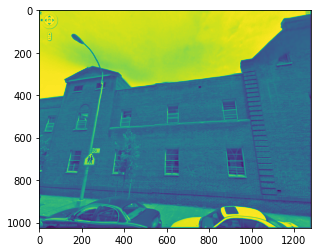

In [9]:
plt.imshow(img1.astype(np.uint8))

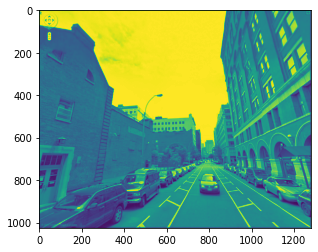

In [5]:
plt.imshow(img2.astype(np.uint8))

In [7]:
descriptor_extractor = SIFT()

In [8]:
descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

In [9]:
descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [10]:
matches12 = match_descriptors(descriptors1,
                              descriptors2,
                              max_ratio=0.6,
                              cross_check=True)

In [11]:
nb_matches = matches12.shape[0]

In [12]:
print(nb_matches)

67


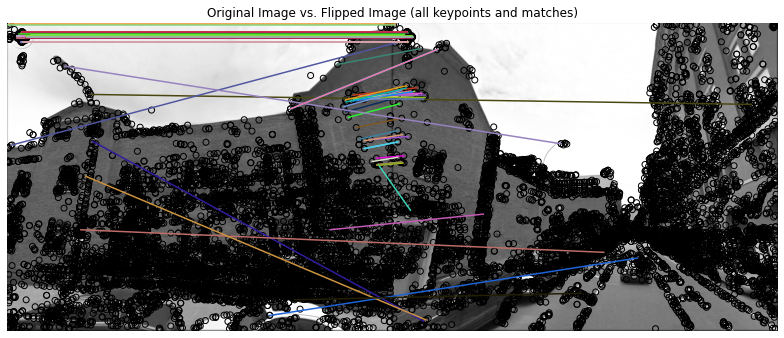

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
plt.gray()
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Original Image vs. Flipped Image (all keypoints and matches)")
plt.tight_layout()
plt.show()

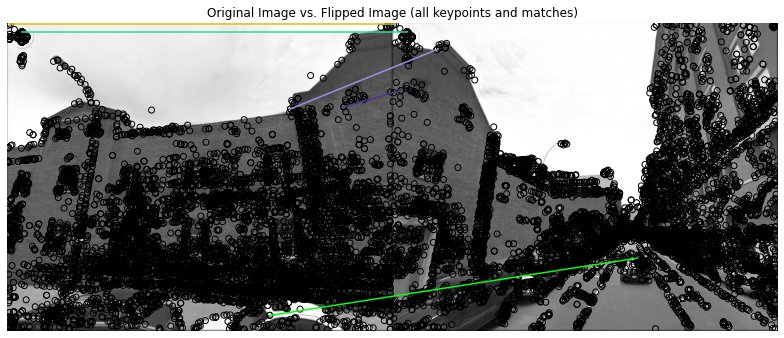

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
plt.gray()
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12[::15])
ax.axis('off')
ax.set_title("Original Image vs. Flipped Image (all keypoints and matches)")
plt.tight_layout()
plt.show()

Conclusion: need to crop images so as to prevent matches between the pad arrows! 
May be possible to detect close images based on SIFT descriptors using a retrieval approach. 